# Optimization of Dissipative Qubit Reset

In [4]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import math

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{ket}[1]{\vert #1\rangle}
\newcommand{Bra}[1]{\left\langle #1\right\vert}
\newcommand{Ket}[1]{\left\vert #1 \right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example illustrates an optimization in an *open* quantum system,
where the dynamics is governed by the Liouville-von Neumann equation. Hence,
states are represented by density matrices $\op{\rho}(t)$ and the time-evolution
operator is given by a general dynamical map $\DynMap$.

## Define parameters

The system consists of a qubit with Hamiltonian
$\op{H}_{q}(t) = - \frac{\omega_{q}}{2} \op{\sigma}_{z} - \frac{\epsilon(t)}{2} \op{\sigma}_{z}$,
where $\omega_{q}$ is an energy level splitting that can be dynamically adjusted
by the control $\epsilon(t)$. This qubit couples strongly to another two-level
system (TLS) with Hamiltonian $\op{H}_{t} = - \frac{\omega_{t}}{2} \op{\sigma}_{z}$ with
static energy level splitting $\omega_{t}$. The coupling strength between both
systems is given by $J$ with the interaction Hamiltonian given by $\op{H}_{\int}
= J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$.

The Hamiltonian for the system of qubit and TLS is

$$
  \op{H}(t)
    = \op{H}_{q}(t) \otimes \identity_{t}
      + \identity_{q} \otimes \op{H}_{t} + \op{H}_{\int}.
$$

In addition, the TLS is embedded in a heat bath with inverse temperature
$\beta$. The TLS couples to the bath with rate $\kappa$. In order to simulate
the dissipation arising from this coupling, we consider the two Lindblad
operators

$$
\begin{split}
\op{L}_{1} &= \sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes \ket{0}\bra{1} \\
\op{L}_{2} &= \sqrt{\kappa N_{th}} \identity_{q} \otimes \ket{1}\bra{0}
\end{split}
$$

with $N_{th} = 1/(e^{\beta \omega_{t}} - 1)$.

In [5]:
omega = 1  # qubit level splitting
g = 0.2*omega  # qubit-TLS coupling
gamma = 0.05*omega  # TLS decay rate
N=0 # inverse bath temperature
T = 15 # final time
nt = 1000  # number of time steps

## Define the Liouvillian

The dynamics of the qubit-TLS system state $\op{\rho}(t)$ is governed by the
Liouville-von Neumann equation

$$
\begin{split}
  \frac{\partial}{\partial t} \op{\rho}(t)
    &= \Liouville(t) \op{\rho}(t) \\
    &= - i \left[\op{H}(t), \op{\rho}(t)\right]
      + \sum_{k=1,2} \left(
            \op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
            - \frac{1}{2}
            \op{L}_{k}^\dagger
            \op{L}_{k} \op{\rho}(t)
            - \frac{1}{2} \op{\rho}(t)
            \op{L}_{k}^\dagger
            \op{L}_{k}
        \right)\,.
\end{split}
$$

In [6]:
def liouvillian(omega, g, gamma, N):
    """Liouvillian for the coupled system of qubit and TLS"""

    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.2*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2))

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    # Cooling on TLS
    L1 = np.sqrt(gamma * (N + 1)) * qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.qeye(2))
    # Heating on TLS
    L2 = np.sqrt(gamma * N) * qutip.tensor(qutip.Qobj([[0, 0], [1, 0]]),qutip.qeye(2))
    

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1, L2])
    L1 = qutip.liouvillian(H=H1)

    # Shift the qubit and TLS into resonance by default
    eps0 = lambda t, args: 0.000000000001
    return [L0, [L1, eps0]], H1


L, H1 = liouvillian(omega, g, gamma, N)


## Define the optimization target

The initial state of qubit and TLS are assumed to be in thermal equilibrium with
the heat bath (although only the TLS is directly interacting with the bath).
Both states are given by

$$
  \op{\rho}_{\alpha}^{th} =
\frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2
\cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
$$

with $\alpha = q,t$. The initial state of the bipartite system
of qubit and TLS is given by the thermal state
$\op{\rho}_{th} = \op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [7]:
rho_th = qutip.Qobj(qutip.tensor(qutip.Qobj(np.diag([1,0])), qutip.Qobj(np.diag([1,0]))))

Since we are ultimately only interested in the state of the qubit, we define
`trace_A`. It returns the reduced state of the qubit
$\op{\rho}_{q} = \tr_{t}\{\op{\rho}\}$ when passed
the state $\op{\rho}$ of the bipartite system.

In [8]:
def trace_A(rho):
    """Partial trace over the A degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qutip.Qobj(rho_q)

The target state is (temporarily) the ground state of the bipartite system,
i.e., $\op{\rho}_{\tgt} = \ket{00}\bra{00}$. Note that in the end we will only
optimize the reduced state of the qubit.

In [9]:
rho_q_trg = qutip.Qobj(np.diag([1, 0]))
rho_T_trg = qutip.Qobj(np.diag([0, 1]))
rho_trg = qutip.tensor(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)

Next, the list of `objectives` is defined, which contains the initial and target
state and the Liouvillian $\Liouville(t)$ that determines the system dynamics.

In [10]:
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]

In the following, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end. Note that at times
$t$ where $S(t)$ vanishes, the updates of the field is suppressed.

In [11]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.005 * T, t_fall=0.005 * T, func='sinsq'
    )

We re-use this function to also shape the guess control $\epsilon_{0}(t)$ to be
zero at $t=0$ and $t=T$. This is on top of the originally defined constant
value shifting the qubit and TLS into resonance.

In [12]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args) * S(t)
    return eps0_shaped


L[1][1] = shape_field(L[1][1])

At last, before heading to the actual optimization below, we assign the shape
function $S(t)$ to the OCT parameters of the control and choose `lambda_a`, a
numerical parameter that controls the field update magnitude in each iteration.

In [13]:
pulse_options = {L[1][1]: dict(lambda_a=1, update_shape=S)}

## Simulate the dynamics of the guess field


In [14]:
tlist = np.linspace(0, T, nt)

In [15]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$ as a constant that
puts qubit and TLS into resonance, but with a smooth switch-on and switch-off.

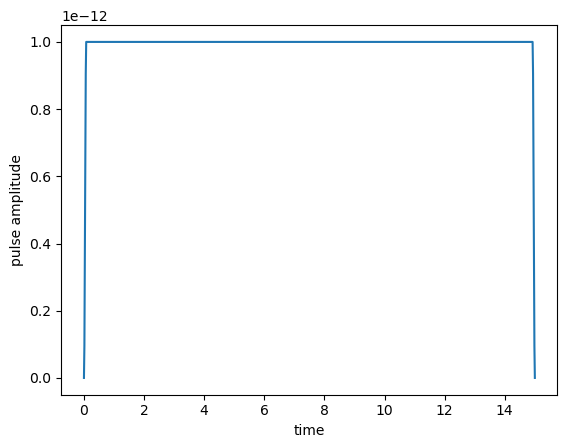

In [16]:
plot_pulse(L[1][1], tlist)

We solve the equation of motion for this guess field, storing the expectation
values for the population in the bipartite levels:


In [17]:
psi00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
psi01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
psi10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
psi11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))
proj_00 = qutip.ket2dm(psi00)
proj_01 = qutip.ket2dm(psi01)
proj_10 = qutip.ket2dm(psi10)
proj_11 = qutip.ket2dm(psi11)

The population dynamics of qubit and TLS ground state show that
both are oscillating and especially the qubit's ground state population reaches
a maximal value at intermediate times $t < T$. This maximum is indeed the
maximum that is physically possible. It corresponds to a perfect swap of
the initial qubit and TLS purities. However, we want to reach this maximum at
final time $T$ (not before), so the guess control is not yet working as desired.

## Optimize

Our optimization target is the ground state $\ket{\Psi_{q}^{\tgt}}
= \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our
optimization functional reads

$$
  J_T = 1 -
\Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}\,,
$$

and we first define `print_qubit_error`, which prints out the
above functional after each iteration.


In [18]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = trace_A(state_T)
        taus.append(state_q_T[1, 1].real)
    J_T = 1 - np.average(taus)
    print("    qubit error: %.1e" % J_T)
    return J_T

In order to minimize the above functional, we need to provide the correct
`chi_constructor` for the Krotov optimization. This is the only place where the
functional (implicitly) enters the optimization.
Given our bipartite system and choice of $J_T$, the equation for
$\op{\chi}(T)$ reads

$$
  \op{\chi}(T)
  =
  \frac{1}{2} \ket{\Psi_{q}^{\tgt}} \bra{\Psi_{q}^{\tgt}} \otimes \op{1}_{2}
  =
  \frac{1}{2} \ket{00}\bra{00} + \frac{1}{2} \ket{01}\bra{01}.
$$

In [19]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in fw_states_T:
        chi_i = qutip.Qobj(qutip.tensor(qutip.Qobj(np.diag([1, 1])),rho_T_trg))
        chis.append(chi_i)
    return chis

We now carry out the optimization for five iterations.

In [20]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.2*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2))

    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)
    
    optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
    )
    fig, [ax_ctr,ax,ay] = plt.subplots(nrows=3, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    W=np.zeros(nt)
    Q=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    W[0]=np.real((EField[1]-EField[0])*np.trace(np.array(H1*optimized_dynamics.states[0])))
    Q[0]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[0]))*(optimized_dynamics.states[1]-optimized_dynamics.states[0]))))
    a=0
    b=0
    c=0
    print(qutip.Qobj(EField[0]))
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      b+=np.real((EField[i]-EField[i-1])*np.trace(np.array(H1*optimized_dynamics.states[i-1])))
      c+=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i-1]))*(optimized_dynamics.states[i]-optimized_dynamics.states[i-1]))))
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      if i==nt-1:
        W[i]= np.real((EField[i]-EField[i-1])*np.trace(np.array(H1*optimized_dynamics.states[i])))+b
        Q[i]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i]))*(optimized_dynamics.states[i]-optimized_dynamics.states[i-1]))))+c
      else:
        W[i]= np.real((EField[i+1]-EField[i])*np.trace(np.array(H1*optimized_dynamics.states[i])))+b
        Q[i]=np.real(np.trace(np.array((H0+H1*qutip.Qobj(EField[i]))*(optimized_dynamics.states[i+1]-optimized_dynamics.states[i]))))+c
      
    
    ay.plot(tlist,np.transpose(EEnergy-W))
    ay.set_title('Difference')
    ax.plot(tlist,np.transpose(EEnergy))
    ax.set_title('Energy of the field')
    plt.legend()
    fig3, az =plt.subplots()
    az.plot(tlist,np.transpose(Q))
    az.set_title("Heat")
    plt.show(fig)
    plt.show(fig3)

In [62]:

# NBVAL_IGNORE_OUTPUT
# the DensityMatrixODEPropagator is not sufficiently exact to guarantee that
# you won't get slightly different results in the optimization when
# running this on different systems
L, H1 = liouvillian(omega, g, gamma, 0)
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]
pulse_options = {L[1][1]: dict(lambda_a=0.005, update_shape=S)}
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    iter_stop=20000,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-8
    ),
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_qubit_error
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('5e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
     ),
      store_all_pulses=True,
)

#plot_iterations(opt_result)


Iteration 0
    objectives:
        1:ρ₀[2⊗2,2⊗2] to ρ₁[2⊗2,2⊗2] via [𝓛₁₆[[2⊗2,2⊗2],[2⊗2,2⊗2]], [𝓛₁₇[[2⊗2,2⊗2],[2⊗2,2⊗2]], u₅(t)]]
    adjoint objectives:
        1:ρ₁₀[2⊗2,2⊗2] to ρ₁₁[2⊗2,2⊗2] via [𝓛₁₈[[2⊗2,2⊗2],[2⊗2,2⊗2]], [𝓛₁₉[[2⊗2,2⊗2],[2⊗2,2⊗2]], u₅(t)]]
    chi_constructor: chis_qubit
    mu: derivative_wrt_pulse
    S(t) (ranges): [0.000000, 1.000000]
    iter_start: 0
    iter_stop: 20000
    duration: 0.0 secs (started at 2023-07-28 17:28:24)
    optimized pulses (ranges): [0.00, 0.00]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 5.00e-03
    storage (bw, fw, fw0): None, None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)


    qubit error: 1.0e+00
Iteration 1
    duration: 0.5 secs (started at 2023-07-28 17:28:24)
    optimized pulses (ranges): [-0.00, 0.00]
    ∫gₐ(t)dt: 2.31e-14
    λₐ: 5.00e-03
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (0.00e+00:0.00π)
    qubit error: 1.0e+00
Iteration 2
    duration: 0.9 secs (started at 2023-07-28 17:28:25)
    optimized pulses (ranges): [-1.75, 26.03]
    ∫gₐ(t)dt: 1.43e+02
    λₐ: 5.00e-03
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.53e-01:0.00π)
    qubit error: 2.9e-01
Iteration 3
    duration: 1.2 secs (started at 2023-07-28 17:28:25)
    optimized pulses (ranges): [-2.01, 26.48]
    ∫gₐ(t)dt: 2.84e+01
    λₐ: 5.00e-03
    storage (bw, fw, fw0): [1 * ndarray(1000)] (0.7 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.74e-01:0.00π)
    qubit error: 1.6e-01
Iteration 4
    duration: 1.3 secs (started at 2023-07-28 17:28:27)
  

In [68]:
import qutip as qt

In [84]:
def get_by_iter(opt_result,iter):
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        if iteration==iter:
            dynamics = objectives[0].mesolve(
                opt_result.tlist,options=qt.Options(atol=1e-10, rtol=1e-8))
            return dynamics.states[-1]

In [87]:
get_by_iter(opt_result,70)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.03902063+0.j         -0.01424676+0.00069077j  0.01229947-0.01076413j
   0.00293711-0.01624221j]
 [-0.01424676-0.00069077j  0.59537414+0.j          0.00532458-0.02094737j
   0.17581507+0.30714858j]
 [ 0.01229947+0.01076413j  0.00532458+0.02094737j  0.04470743+0.j
  -0.02329199+0.00718219j]
 [ 0.00293711+0.01624221j  0.17581507-0.30714858j -0.02329199-0.00718219j
   0.32089781+0.j        ]]

In [81]:
from scipy import linalg

In [82]:
def trace_A(rho):
    """Partial trace over the TLS degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qt.Qobj(rho_q)

Giovannetti

In [ ]:
def HA_coeff(t, args):
      return  np.exp(-(t*1j*omega))

def HB_coeff(t, args):
      return  np.exp((t*1j*omega))


def hamiltonian(omega, g,F):
    """Liouvillian for the coupled system of qubit and TLS"""
    sminus=qt.Qobj(np.array([[0,1],[0,0]]))
    splus=qt.Qobj(np.array([[0,0],[1,0]]))
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_A = F*splus
    H1_B = F*sminus

    # drift TLS Hamiltonian
    H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1A = qutip.tensor(H1_A, qutip.qeye(2))
    H1B = qutip.tensor(H1_B, qutip.qeye(2))
    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(qutip.Qobj(np.array([[0, 0], [1, 0]])),qutip.Qobj(np.array([[0, 1], [0, 0]])))+qutip.tensor(qutip.Qobj(np.array([[0, 1], [0, 0]])),qutip.Qobj(np.array([[0, 0], [1, 0]]))))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1A = qutip.Qobj(H1A)
    H1B = qutip.Qobj(H1B)
    return [H0,[H1A,HA_coeff],[H1B,HB_coeff]]

In [ ]:
def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues
    
def eigenvectors(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

/tmp/ipykernel_772/3532739376.py:32: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=ergotropy[i]/energy[i]


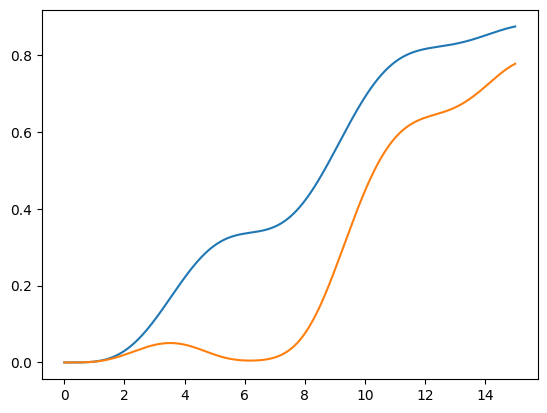

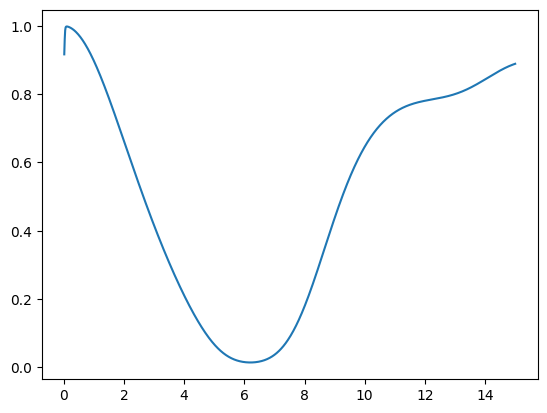

In [ ]:
import qutip as qt
import numpy as np
from numpy import linalg as npla
sminus=qt.Qobj(np.array([[0,1],[0,0]]))
splus=qt.Qobj(np.array([[0,0],[1,0]]))
F=0.5
g=0.2
gamma=0.05
omega=1
H=hamiltonian(omega,g,F)
psi0=qt.tensor(qt.basis(2,0),qt.basis(2,0))
T = 15  # final time
nt = 1000
t=np.linspace(0,T,nt)
N=0
H0=omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
output = qt.mesolve(H, psi0, t, [qt.tensor(np.sqrt(gamma*(N+1))*sminus,qt.qeye(2)),qt.tensor(np.sqrt(gamma*N)*splus,qt.qeye(2))], [])
energy=np.zeros(len(t))
ergotropy=np.zeros(len(t))
ratio=np.zeros(len(t))
for i in range (0,len(t)):
  rho_A=output.states[i].ptrace(1)


  rho_f=qt.Qobj(eigenvalues(rho_A)[1]*qt.basis(2,0)*qt.basis(2,0).dag()+eigenvalues(rho_A)[0]*qt.basis(2,1)*qt.basis(2,1).dag())
  #r=np.sqrt(((rho_A*qt.sigmax()).tr())**2+((rho_A*qt.sigmay()).tr())**2+((rho_A*qt.sigmaz()).tr())**2)
  #sminusexp=(rho_A*sminus).tr()
  #splusexp=(rho_A*splus).tr()
  #zexp=(rho_A*qt.sigmaz()).tr()
  energy[i]=np.real((rho_A*H0).tr())
  ergotropy[i]=np.real(((rho_A-rho_f)*H0).tr())
  ratio[i]=ergotropy[i]/energy[i]
plt.plot(t,energy)
plt.plot(t,ergotropy)
plt.figure()
plt.plot(t,ratio)


/tmp/ipykernel_772/1839839500.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=Ergotropy[i]/Energy[i]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 7.67333726e-01+0.00000000e+00j -1.64677958e-10-2.37452975e-11j]
 [-1.64677958e-10+2.37452975e-11j  2.32666274e-01+0.00000000e+00j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 7.67333726e-01+0.00000000e+00j -1.64677958e-10-2.37452975e-11j]
 [-1.64677958e-10+2.37452975e-11j  2.32666274e-01+0.00000000e+00j]]


/tmp/ipykernel_772/1839839500.py:40: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t,ergotropy/energy,label="Gio")


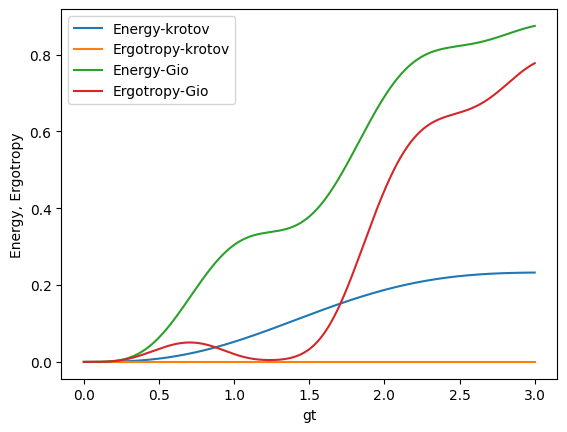

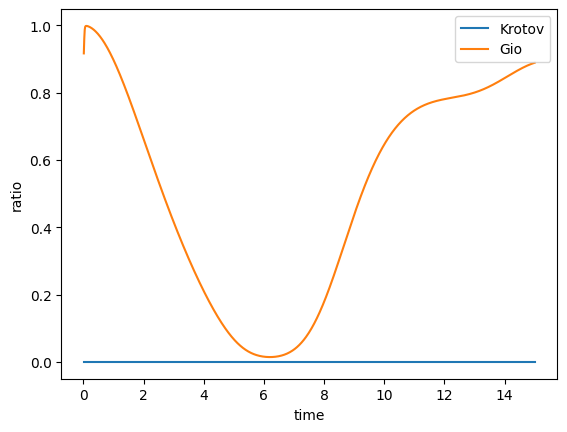

In [ ]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
ratio=np.zeros(nt)

for i in range(0,nt):
  FinalRho=trace_A(np.array(optimized_dynamics.states[i]))
  Rho_f=eigenvalues(FinalRho)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalRho)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalRho)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_f-FinalRho))))
  ratio[i]=Ergotropy[i]/Energy[i]



plt.plot(g*tlist,Energy,label='Energy-krotov')
plt.plot(g*tlist,Ergotropy,label='Ergotropy-krotov')
plt.plot(g*t,energy,label="Energy-Gio")
plt.plot(g*t,ergotropy,label="Ergotropy-Gio")



plt.xlabel("gt")
plt.ylabel("Energy, Ergotropy")
plt.legend()  


plt.figure()
plt.plot(tlist,ratio,label="Krotov")
plt.plot(t,ergotropy/energy,label="Gio")
plt.xlabel("time")
plt.ylabel("ratio")

plt.legend()

print(trace_A(opt_result.states[0]))
print(opt_result.states[0].ptrace(1))

In [ ]:
T=15
EField=np.transpose(np.array(opt_result.optimized_controls))
EEnergy=np.zeros(len(tlist))
EEnergy[0]=(np.square(EField[0]))*(T/nt)
a=0
for i in range (1,nt):
    a+=np.square(EField[i-1])
    EEnergy[i]=(np.square(EField[i])+a)*(T/nt)

print(EEnergy[nt-1])

5.911862846593246e-23


Giovanneti is 29.012

## Simulate the dynamics of the optimized field

The plot of the optimized field shows that the optimization slightly shifts
the field such that qubit and TLS are no longer perfectly in resonance.

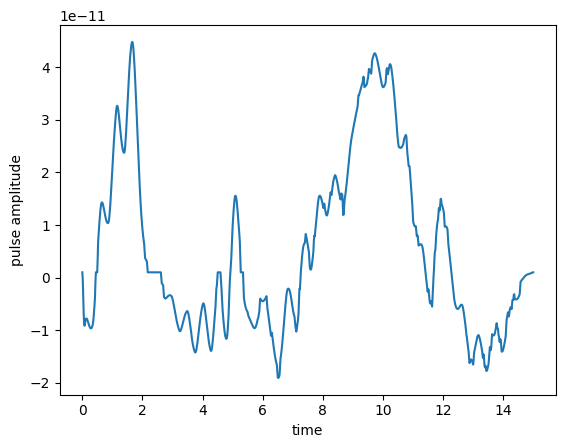

In [ ]:
plot_pulse(opt_result.optimized_controls[0], tlist)

This slight shift of qubit and TLS out of resonance delays the population
oscillations between qubit and TLS ground state such that the qubit ground
state is maximally populated at final time $T$.

In [ ]:
print(Energy[nt-1])
print(Ergotropy[nt-1])
print(Ergotropy[nt-1]/Energy[nt-1])

0.23266617728962868
-0.0
-0.0


In [ ]:
 H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian


    # drift TLS Hamiltonian
H0_T = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))

    # Lift Hamiltonians to joint system operators
H0 = np.kron(H0_q, np.identity(2)) + np.kron(np.identity(2), H0_T)


    # qubit-TLS interaction
H_int =  g*(np.kron(np.array([[0, 0], [1, 0]]),np.array([[0, 1], [0, 0]]))+np.kron(np.array([[0, 1], [0, 0]]),np.array([[0, 0], [1, 0]])))

    # convert Hamiltonians to QuTiP objects
H0 = qutip.Qobj(H0 + H_int)


    # Define Lindblad operators
N = 1.0 / (np.exp(beta * omega) - 1.0)
    # Cooling on TLS
L1 = np.sqrt(gamma * (N + 1)) * np.kron(np.array([[0, 1], [0, 0]]),np.identity(2))
    # Heating on TLS
L2 = np.sqrt(gamma * N) * np.kron(np.array([[0, 0], [1, 0]]),np.identity(2))
    

    # convert Lindblad operators to QuTiP objects
L1 = qutip.Qobj(L1)
L2 = qutip.Qobj(L2)

    # generate the Liouvillian




Int1=0
Int2=0
DeltaT=T/nt
for i in range (0,nt):
  rho=np.array(optimized_dynamics.states[i])
  EField=np.transpose(np.array(opt_result.optimized_controls))
  H1_q = -0.5*qutip.operators.sigmax()*EField[i,0]
  H1 = qutip.Qobj(np.kron(H1_q, qutip.qeye(2)))
  L0 = (qutip.superoperator.liouvillian(H0+H1, c_ops=[L1, L2])).dag()
  L = qutip.superoperator.liouvillian(H0+H1, c_ops=[L1, L2])(optimized_dynamics.states[i])
  HS=np.real(np.sqrt(np.trace(np.array(L.dag()*L))))
  Int1+=1/T*(T/nt)*HS
  Int2+=1/T*(T/nt)*np.sqrt(np.trace(np.array(L0(optimized_dynamics.states[0])**2)))

F=np.real(np.sqrt(np.trace(np.dot(np.array(optimized_dynamics.states[nt-1]),np.array(optimized_dynamics.states[0])))))
L=np.arccos(F)
numerator=4*(L**2)
denominator=Int2*(math.pi)*(math.pi)
Tau2=np.real(numerator/denominator)
Tau1=np.sin(L)**2/Int1
print(Tau1)
print(Tau2)
print(T)
print(T-Tau2)

NameError: name 'beta' is not defined

In [1]:
opt.result

NameError: name 'opt' is not defined